In [46]:
import logging
import os
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from sampler import MultilabelBalancedRandomSampler

def get_dataloaders(root, t_hours, n_bins, validation, task, dt=1.0, dynamic=True,
                    shuffle=True, pin_memory=True, batch_size=128,
                    logger=logging.getLogger(__name__)):
    """A generic data loader.

    Parameters
    ----------
    root: str
        Root directory.

    t_hours: int


    n_bins: int


    validation: bool
        Whether or not to return a validation DataLoader also (when training).
        
    task: pheno/mortality
        what task to predict

    dt: float, optional
        Time step between intervals.

    dynamic: bool, optional
        Whether the model should predict in a dynamic fashion.

    shuffle: bool, optional
        Whether to shuffle data during training.

    pin_memory: bool, optional
        Whether to pin memory in the GPU when using CUDA.

    batch_size: int, optional

    logger: logging.Logger, optional
    """
    pin_memory = pin_memory and torch.cuda.is_available

    arrs = np.load(
        os.path.join(root, '_dicts', f'{t_hours}_{n_bins}_arrs_new.npy'),
        #os.path.join(root, '_dicts', f'{t_hours}_{n_bins}_arrs.npy'),
        allow_pickle=True).item()
    if validation:
        if task == 'pheno':
            X_train, X_valid, y_train, y_valid = train_test_split(
                #arrs['X_train'], arrs['Y_train'],
                #arrs['X'], arrs['Y'],
                arrs['X'], arrs['pheno'],
                #test_size=1000, stratify=arrs['Y_train'])
                test_size=1000, stratify=arrs['Y'])

            train_dataset = EHR(X_train, y_train, t_hours, dt, dynamic)

            valid_dataset = EHR(X_valid, y_valid, t_hours, dt, dynamic)
            
        else:
            X_train, X_valid, y_train, y_valid = train_test_split(
                #arrs['X_train'], arrs['Y_train'],
                arrs['X'], arrs['Y'],
                #arrs['X'], arrs['pheno'],
                #test_size=1000, stratify=arrs['Y_train'])
                test_size=1000, stratify=arrs['Y'])

            train_dataset = EHR(X_train, y_train, t_hours, dt, dynamic)

            valid_dataset = EHR(X_valid, y_valid, t_hours, dt, dynamic)
        
        
        if task != 'pheno':
            train_dataset_pos = EHR_pos(X_train, y_train, t_hours, dt, dynamic)
            train_dataset_neg = EHR_neg(X_train, y_train, t_hours, dt, dynamic)
            
            valid_dataset_pos = EHR_pos(X_valid, y_valid, t_hours, dt, dynamic)
            valid_dataset_neg = EHR_neg(X_valid, y_valid, t_hours, dt, dynamic)
            
            train_dataloader_pos = DataLoader(train_dataset_pos,
                                          batch_size=int(batch_size/2),
                                          shuffle=shuffle,
                                          pin_memory=pin_memory)
            train_dataloader_neg = DataLoader(train_dataset_neg,
                                          batch_size=int(batch_size/2),
                                          shuffle=shuffle,
                                          pin_memory=pin_memory)        
            train_dataloader = DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          pin_memory=pin_memory)


            valid_dataloader_pos = DataLoader(valid_dataset_pos,
                                          batch_size=int(batch_size/2),
                                          shuffle=False,
                                          pin_memory=pin_memory)
            valid_dataloader_neg = DataLoader(valid_dataset_neg,
                                          batch_size=int(batch_size/2),
                                          shuffle=False,
                                          pin_memory=pin_memory)
            valid_dataloader = DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=pin_memory)

            return train_dataloader_pos, train_dataloader_neg, train_dataloader, \
        valid_dataloader_pos, valid_dataloader_neg, valid_dataloader
        
        else:
            train_dataloader_rand = DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          pin_memory=pin_memory)

            train_sampler = MultilabelBalancedRandomSampler(train_dataset.Y, class_choice="least_sampled")
            train_loader_bal = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
            
            
            valid_dataloader_rand = DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          pin_memory=pin_memory)
            
            valid_sampler = MultilabelBalancedRandomSampler(valid_dataset.Y, class_choice="least_sampled")
            valid_loader_bal = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)
            
            return train_loader_bal, train_dataloader_rand, valid_loader_bal, valid_dataloader_rand

    else:
        test_dataset = EHR(
            arrs['X_test'], arrs['Y_test'], t_hours, dt, dynamic)
        test_dataloader = DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     pin_memory=pin_memory)

        return test_dataloader, None


class EHR(Dataset):
    """
    EHR Dataset.

    Parameters
    ----------
    X: numpy.ndarray
        Array containing patient sequences, shape (n_patients, 10000, 2)

    Y: numpy.ndarray
        Array containing patient outcomes, shape (n_patients,)

    t_hours: int, optional


    dt: float, optional
        Time step between intervals.

    dynamic: bool, optional
        Whether the model should predict in a dynamic fashion.

    logger: logging.Logger, optional
    """

    def __init__(self, X, Y, t_hours=48, dt=1.0, dynamic=True,
                 logger=logging.getLogger(__name__)):

        self.logger = logger

        self.X = torch.tensor(X)
        if dynamic:  # shape (n_patients,) -> (n_patients, n_intervals)
            Y = np.tile(Y[:, None], (1, int(t_hours / dt)))
        temp = []
        for i in Y:
            temp.append(i.tolist())
        Y = temp
        self.Y = torch.tensor(Y).float()

        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        #return self.X[idx], self.Y[idx]
        example = Variable(torch.tensor(self.X[index]), requires_grad=False)
        labels = Variable(torch.tensor(self.Y[index]), requires_grad=False)
        return {"example": example, "labels": labels}

    
class EHR_pos(Dataset):
    """
    EHR Dataset.

    Parameters
    ----------
    X: numpy.ndarray
        Array containing patient sequences, shape (n_patients, 10000, 2)

    Y: numpy.ndarray
        Array containing patient outcomes, shape (n_patients,)

    t_hours: int, optional


    dt: float, optional
        Time step between intervals.

    dynamic: bool, optional
        Whether the model should predict in a dynamic fashion.

    logger: logging.Logger, optional
    """

    def __init__(self, X, Y, t_hours=48, dt=1.0, dynamic=True,
                 logger=logging.getLogger(__name__)):

        self.logger = logger
        
        # balanced batch
        pos_idx = np.where(Y == 1)[0]
        
        X_pos = torch.Tensor(X[pos_idx])

        Y_pos = torch.Tensor(Y[pos_idx])

        self.X_pos = torch.tensor(X_pos)
        
        if dynamic:  # shape (n_patients,) -> (n_patients, n_intervals)
            Y_pos = np.tile(Y_pos[:, None], (1, int(t_hours / dt)))
            
        self.Y_pos = torch.tensor(Y_pos).float()

        self.len = len(self.X_pos)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X_pos[idx], self.Y_pos[idx]
    
    
class EHR_neg(Dataset):
    """
    EHR Dataset.

    Parameters
    ----------
    X: numpy.ndarray
        Array containing patient sequences, shape (n_patients, 10000, 2)

    Y: numpy.ndarray
        Array containing patient outcomes, shape (n_patients,)

    t_hours: int, optional


    dt: float, optional
        Time step between intervals.

    dynamic: bool, optional
        Whether the model should predict in a dynamic fashion.

    logger: logging.Logger, optional
    """

    def __init__(self, X, Y, t_hours=48, dt=1.0, dynamic=True,
                 logger=logging.getLogger(__name__)):

        self.logger = logger
        
        # balanced batch
        neg_idx = np.where(Y == 0)[0]
        
        X_neg = torch.Tensor(X[neg_idx])

        Y_neg = torch.Tensor(Y[neg_idx])

        self.X_neg = torch.tensor(X_neg)
        
        if dynamic:  # shape (n_patients,) -> (n_patients, n_intervals)
            Y_neg = np.tile(Y_neg[:, None], (1, int(t_hours / dt)))
            
        self.Y_neg = torch.tensor(Y_neg).float()

        self.len = len(self.X_neg)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X_neg[idx], self.Y_neg[idx]

In [22]:
root = '../../flexible-ehr/data/root_dicts'
t_hours = 48
n_bins = 20
arrs = np.load(
        os.path.join(root, '_dicts', f'{t_hours}_{n_bins}_arrs_new.npy'),
        #os.path.join(root, '_dicts', f'{t_hours}_{n_bins}_arrs.npy'),
        allow_pickle=True).item()

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(
                arrs['X'], arrs['pheno'],
                test_size=1000, stratify=arrs['Y'])

In [27]:
y_train.shape

(17028, 25)

In [47]:
dt = 1.0
dynamic = True

train_dataset = EHR(X_train, y_train, t_hours, dt, dynamic)

In [48]:
train_dataset.Y

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 0.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 0.]]])

In [49]:
train_dataset

In [98]:
import torch
import numpy as np

from sampler import MultilabelBalancedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


class EHR_pheno(Dataset):
    def __init__(self, X, Y, n_examples, n_features, n_classes, mean_labels_per_example):
        #self.n_examples = n_examples
        #self.n_features = n_features
        #self.n_classes = n_classes
        #self.X = np.random.random([self.n_examples, self.n_features])

        #class_probabilities = np.random.random([self.n_classes])
        #class_probabilities = class_probabilities / sum(class_probabilities)
        #class_probabilities *= mean_labels_per_example
        #self.Y = (
        #    np.random.random([self.n_examples, self.n_classes]) < class_probabilities
        #).astype(int)
        self.X = torch.tensor(X)
        temp = []
        for i in Y:
            temp.append(i.tolist())
        Y = temp
        self.Y = torch.tensor(Y).float()

        self.len = len(self.X)
        
    def __len__(self):
        #return self.n_examples
        return self.len

    def __getitem__(self, index):
        #example = Variable(torch.tensor(self.X[index]), requires_grad=False)
        #labels = Variable(torch.tensor(self.Y[index]), requires_grad=False)
        #return {"example": example, "labels": labels}
        return self.X[index], self.Y[index]

def get_data_loaders(batch_size, val_size):
    dataset = RandomDataset(20000, 100, 20, 2)

    # Split into training and validation
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    split = int(np.floor(val_size * len(dataset)))
    train_idx, validate_idx = indices[split:], indices[:split]

    train_sampler = MultilabelBalancedRandomSampler(
        dataset.Y, train_idx, class_choice="least_sampled"
    )
    validate_sampler = SubsetRandomSampler(validate_idx)

    # Create data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validate_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=validate_sampler,
    )
    return train_loader, validate_loader

'''
def main():
    epochs = 2
    train_loader, validate_loader = get_data_loaders(batch_size=512, val_size=0.2)

    for epoch in range(epochs):
        print("================ Training phase ===============")
        for batch in train_loader:
            examples = batch["example"]
            labels = batch["labels"]
            print("Label counts per class:")
            sum_ = labels.sum(axis=0)
            print(sum_)
            print("Difference between min and max")
            print(max(sum_) - min(sum_))
            print("")
        print("")

        print("=============== Validation phase ==============")
        for batch in validate_loader:
            examples = batch["example"]
            labels = batch["labels"]
            print("Label counts per class:")
            sum_ = labels.sum(axis=0)
            print(sum_)
            print("Difference between min and max")
            print(max(sum_) - min(sum_))
            print("")
        print("")


if __name__ == "__main__":
    main()
'''

'\ndef main():\n    epochs = 2\n    train_loader, validate_loader = get_data_loaders(batch_size=512, val_size=0.2)\n\n    for epoch in range(epochs):\n        print("================ Training phase ===============")\n        for batch in train_loader:\n            examples = batch["example"]\n            labels = batch["labels"]\n            print("Label counts per class:")\n            sum_ = labels.sum(axis=0)\n            print(sum_)\n            print("Difference between min and max")\n            print(max(sum_) - min(sum_))\n            print("")\n        print("")\n\n        print("=============== Validation phase ==============")\n        for batch in validate_loader:\n            examples = batch["example"]\n            labels = batch["labels"]\n            print("Label counts per class:")\n            sum_ = labels.sum(axis=0)\n            print(sum_)\n            print("Difference between min and max")\n            print(max(sum_) - min(sum_))\n            print("")\n       

In [99]:
dataset = EHR_pheno(X_train, y_train, 20000, 100, 20, 2)

In [100]:
dataset

In [101]:
# Split into training and validation
#dataset = train_dataset
val_size = 0.2
batch_size = 128

indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(np.floor(val_size * len(dataset)))
train_idx, validate_idx = indices[split:], indices[:split]

train_sampler = MultilabelBalancedRandomSampler(
    dataset.Y, train_idx, class_choice="least_sampled"
)
validate_sampler = SubsetRandomSampler(validate_idx)

# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,)
validate_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=validate_sampler,
)

In [111]:
from torch import nn

y_pred = torch.Tensor([0.8, 0.2, 0.2, 0.4, 0.3])
y_true = torch.Tensor([1, 0, 1, 0, 0])

criterion = nn.BCEWithLogitsLoss()
criterion(y_pred, y_true)

tensor(0.7069)

In [107]:
from torch import optim

model = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
y = torch.tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(20):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print('Loss: {:.3f}'.format(loss.item()))

Loss: 0.861
Loss: 0.656
Loss: 0.512
Loss: 0.411
Loss: 0.339
Loss: 0.286
Loss: 0.246
Loss: 0.216
Loss: 0.191
Loss: 0.172
Loss: 0.156
Loss: 0.142
Loss: 0.131
Loss: 0.121
Loss: 0.112
Loss: 0.105
Loss: 0.098
Loss: 0.093
Loss: 0.087
Loss: 0.083


In [108]:
output

tensor([[ 2.4531, -2.4313,  2.3907, -2.6001, -2.3827]],
       grad_fn=<AddmmBackward>)

In [109]:
y

tensor([[1., 0., 1., 0., 0.]])

In [114]:
np.array([1, 2, 3], [1]).ndim

1

In [118]:
a = np.zeros((2,3))

In [119]:
a

array([[0., 0., 0.],
       [0., 0., 0.]])

In [120]:
a[:, 2]

array([0., 0.])

## trainable cost plot

In [63]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
epoch = 0

with open(f'../saved/rand_loss_r_ls{epoch}.npy', 'rb') as f:
    rand_loss_r_ls = np.load(f, allow_pickle=True)
with open(f'../saved/bal_loss_r_ls{epoch}.npy', 'rb') as f:
    bal_loss_r_ls = np.load(f, allow_pickle=True)

In [65]:
rand_loss_r_cpu = []
for rand_loss in rand_loss_r_ls:
    rand_loss_r_cpu.append(rand_loss*2)
    
bal_loss_r_cpu = []
for bal_loss in bal_loss_r_ls:
    bal_loss_r_cpu.append(bal_loss*2)

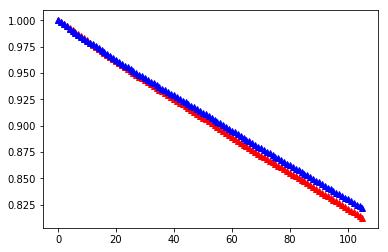

In [79]:
rand_loss_r_cpu = rand_loss_r_cpu[:int(len(rand_loss_r_cpu)/2)]
bal_loss_r_cpu = bal_loss_r_cpu[:int(len(bal_loss_r_cpu)/2)]
x_ls = [i for i in range(len(rand_loss_r_cpu))]

plt.plot(x_ls, rand_loss_r_cpu, 'r^')
plt.plot(x_ls, bal_loss_r_cpu, 'b^')

In [68]:
rand_loss_r_new = []
for idx, rand_loss in enumerate(rand_loss_r_cpu):
    if idx % 4 == 0:
        rand_loss_r_new.append(rand_loss)

In [69]:
bal_loss_r_new = []
for idx, bal_loss in enumerate(bal_loss_r_cpu):
    if idx % 2 == 0:
        bal_loss_r_new.append(bal_loss)
        
bal_loss_r_new = bal_loss_r_new[:len(rand_loss_r_new)]

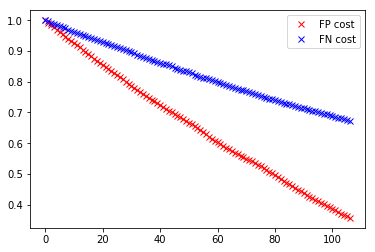

In [108]:
x_ls = [i for i in range(len(rand_loss_r_new))]

plt.plot(x_ls, rand_loss_r_new, 'rx', label='FP cost')
plt.plot(x_ls, bal_loss_r_new, 'bx', label='FN cost')
plt.legend()

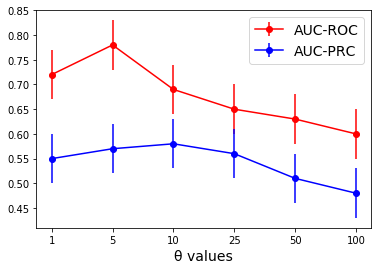

In [106]:
x = ['1', '5', '10', '25', '50', '100']
auc = [0.72, 0.78, 0.69, 0.65, 0.63, 0.60]
auprc = [0.55, 0.57, 0.58, 0.56, 0.51, 0.48]
yerr= np.linspace(0.05, 0.2, 10)
plt.errorbar(x, auc, fmt='ro-', yerr=0.05, label='AUC-ROC')
plt.errorbar(x, auprc, fmt='bo-',yerr=0.05, label='AUC-PRC')
#plt.errorbar(x, y, yerr=0.1)
plt.xlabel('θ values', fontsize=14)
plt.legend(fontsize=14)

In [95]:
np.linspace(0.05, 0.2, 10)

array([0.05      , 0.06666667, 0.08333333, 0.1       , 0.11666667,
       0.13333333, 0.15      , 0.16666667, 0.18333333, 0.2       ])